## Prepare the environment and data

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Final Project") \
     .getOrCreate()
sc = spark.sparkContext      # get the context
sc

<SparkContext master=yarn appName=Final Project>

In [3]:
import pandas as pd

In [4]:
features = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/fma_dataset.csv")

In [5]:
tracks = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/tracks.csv")

In [22]:
#Combine two csv file by tracks_id column
Join_table = features.join(tracks["track_id","genre_top"], features.feature == tracks.track_id)

In [23]:
#convert the type of track_id column into integer
from pyspark.sql.types import *
Join_table = Join_table.withColumn("track_id", Join_table["track_id"].cast(IntegerType()))

In [24]:
#order by track_id column
from pyspark.sql.functions import col
Join_table = Join_table.orderBy(Join_table.track_id)

In [25]:
#delete duplicate column
Join_table = Join_table.drop('feature')

#### .printSchema()

There are 520 columns in the following dataframe. 
The first 518 columns are features extracted by LibROSA, which is a python package for music and audio analysis. 
The last two columns are respectively the identity column "track_id" and the target variable "genre_top".

In [49]:
#Join_table.printSchema()

Create a TempView and filter out distinct values of target variables:

Now we have four categories: album, live performance, single tracks and radio program.

In [36]:
Join_table.createOrReplaceTempView("Join_table")

#### cleaned_df
This dataframe now has an identity column, a label column and 518 feature columns for feature engineering and modeling.

In [41]:
cleaned_df = spark.sql("select * from Join_table where genre_top in ('Experimental','Electronic','Rock','Instrumental','Pop','Folk','Hip-Hop','International','Jazz','Classical','Country','Spoken','Blues') ")

In [42]:
cleaned_df.count() # The No. of row of the dataframe

11105

## Exploratory data analysis

### 1. Check the balance of the target variable

In [45]:
import pyspark.sql.functions as F
from pyspark.sql.functions import bround
check_balance = cleaned_df.groupBy("genre_top").count()
check_balance = check_balance.withColumn("Percentage",bround(F.col("count")/11105,2))

In [46]:
check_balance.show()

+-------------+-----+----------+
|    genre_top|count|Percentage|
+-------------+-----+----------+
|International|  276|      0.02|
| Instrumental|  689|      0.06|
|         Rock| 2557|      0.23|
|         Jazz|  125|      0.01|
|         Folk|  919|      0.08|
|    Classical|  160|      0.01|
|        Blues|   13|       0.0|
| Experimental| 1993|      0.18|
|       Spoken|   64|      0.01|
|          Pop|  554|      0.05|
|   Electronic| 3069|      0.28|
|      Country|   68|      0.01|
|      Hip-Hop|  618|      0.06|
+-------------+-----+----------+



The data is highly imbalanced, The "Album" label takes up 90% among all labels and all other three label types only take up 10%.

### 2. Check the collinearity of features

#### The features we selected for supervised learning:
 
1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. spectral_rolloff463
9. tonnetz470
10. zcr512

## Unsupervised Learning: K-means Clustering

### 1. Prepare the data

Remove "spectral_rolloff463" and "genre_top" from our data and convert all data to float. We pretend there are no labels in our data set.

In [82]:
cols = ['track_id','chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']
unsup_df = cleaned_df[cols]
for col in unsup_df.columns:
    unsup_df = unsup_df.withColumn(col,unsup_df[col].cast('float'))

In [83]:
unsup_df.printSchema()

root
 |-- track_id: float (nullable = true)
 |-- chroma_cens1: float (nullable = true)
 |-- chroma_cqt85: float (nullable = true)
 |-- chroma_stft169: float (nullable = true)
 |-- mfcc253: float (nullable = true)
 |-- spectral_bandwidth400: float (nullable = true)
 |-- spectral_centroid407: float (nullable = true)
 |-- spectral_contrast414: float (nullable = true)
 |-- tonnetz470: float (nullable = true)
 |-- zcr512: float (nullable = true)



Drop the null values

In [84]:
unsup_df = unsup_df.na.drop()

Create a feature vector which stores all features as an array of floats

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

In [95]:
selected_features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']
vecAssembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_kmeans = vecAssembler.transform(unsup_df).select("track_id","features")

In [96]:
df_kmeans.show()

+--------+--------------------+
|track_id|            features|
+--------+--------------------+
|     2.0|[7.18065261840820...|
|     3.0|[1.88896334171295...|
|     5.0|[0.52756297588348...|
|   134.0|[0.91844475269317...|
|   139.0|[-0.0208688862621...|
|   141.0|[0.17289805412292...|
|   170.0|[-0.4299543499946...|
|   171.0|[1.31426870822906...|
|   172.0|[0.44440415501594...|
|   175.0|[2.52066993713378...|
|   176.0|[0.83924043178558...|
|   178.0|[-0.7247010469436...|
|   179.0|[2.66432499885559...|
|   189.0|[0.34828430414199...|
|   191.0|[-0.0221101082861...|
|   192.0|[-0.7870702147483...|
|   195.0|[-1.1793559789657...|
|   196.0|[-0.0818014964461...|
|   199.0|[0.42263925075531...|
|   201.0|[0.10787744820117...|
+--------+--------------------+
only showing top 20 rows



### 2. Optimize choice of k

To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

In [87]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

Text(0, 0.5, 'cost')

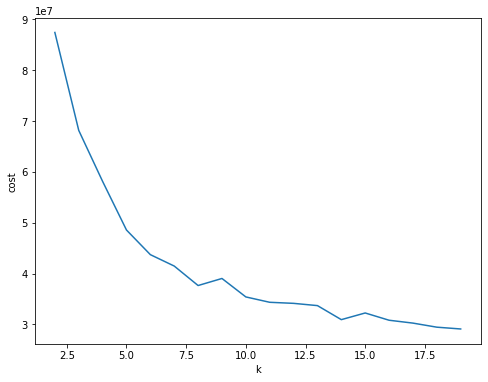

In [88]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Look like there is very little gain after k=13 , which is also the number of track genres we have selected, so we stick to that choice when processing the full data set.

### 3. Train the model

Once the training has converged we can print out the centroids of the 13 clusters.

In [97]:
k = 13
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.21655024 -0.41141123 -0.54527835  3.8977303   2.42922718  4.977976
  1.89398822  1.43360207  7.03974832]
[ 3.16359112e+00  3.43116748e+00  1.45736371e+00  3.28594173e+01
  3.29049624e+02  1.16055125e+03  3.22364656e+00 -8.47210975e-02
  2.14575064e+02]
[ 0.39966276  1.93929483  0.2112936  12.42430823 38.4036166  78.70402688
  2.36616127  1.12482204 14.89843401]
[  0.71331371   0.70940756  -0.54698736  24.40717687 148.63382447
 546.97521925   2.38725005   0.95771802  66.69623354]
[ 5.01778376e-01  1.34536213e+00 -1.86170683e-02  6.42110170e+00
  2.55074518e+01  1.31203147e+02  2.16097491e+00  5.60307997e-01
  3.66996414e+02]
[-3.91856904e-01  3.03350608e-01  9.61647823e-01  1.86545524e+01
  1.10590786e+02  1.14665822e+03  1.69945745e+00  1.95809383e-01
  1.84865979e+03]
[5.97638039e-01 8.14207399e-01 3.59195134e-01 5.27454660e+00
 2.70097820e+01 2.04986818e+02 1.85152189e+00 5.13816007e-01
 8.41034902e+02]
[ 2.85755411e-01  1.54249376e-02 -1.22562692e-01  4.4283430

Make predictions

### 4. Evaluate the model

Evaluate clustering

In [94]:
cost = model.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 20292685.273604553


Evaluate clustering by computing Silhouette score.

* If this number is negative, the data cannot be separated at all.
* Values closer to 1 indicate maximum separation.
* Values close to zero mean the data could barely be separated.

In [98]:
predictions = model.transform(df_kmeans)

In [99]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6084846168635296


The result 0.61 is not bad.

In [101]:
sc.stop()